In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
plt.rc('font', family='NanumGothicCoding')


from skimage.metrics import structural_similarity as compare_ssim
import imutils

from changeDetector import detectChange #############################

In [2]:
def read_img(path):
    img = cv2.imread(path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img, gray


def plot_two(shape, imgs, title=None):
    fig, axes = plt.subplots(*shape, figsize=(20, 8))
    for i, img in enumerate(imgs):
        axes[i].imshow(img, 'gray')
        if title:
            axes[i].set_title(title.split('&')[i], size=20, weight='semibold')
    plt.tight_layout()
    plt.show()


def plot_diff(path1, path2, shape=(1,2)):
    img1 = read_img(path1)[0]
    img2 = read_img(path2)[0]
    
    bboxes = detectChange(img1, img2) #############################
        
    for bbox in bboxes:
        (x, y, w, h) = bbox
        cv2.rectangle(img1, (x, y), (x + w, y + h), (0, 0, 255), 10)
        cv2.rectangle(img2, (x, y), (x + w, y + h), (0, 0, 255), 10)

    plot_two(shape, [img1, img2], title=f'{path1} & {path2}')

In [3]:
plot_diff('../KakaoTalk_20220528_151025237.jpg', '../KakaoTalk_20220528_151025237_01.jpg')

TypeError: detectChange() missing 2 required positional arguments: 'before_bboxes' and 'after_bboxes'

In [100]:
def plot_all(path1, path2):
    global diff
    img1, gray1 = read_img(path1)
    img2, gray2 = read_img(path2)

    fig, axes = plt.subplots(1, 2, figsize=(14, 7))

    axes[0].imshow(img1)
    axes[0].set_title(f'{path1}', size=20)

    axes[1].imshow(img2)
    axes[1].set_title(f'{path2}', size=20)
    plt.show()

    fig, axes = plt.subplots(1, 4, figsize=(14, 10))

    #compare
    (score, diff) = compare_ssim(gray1, gray2, full=True)
    print(score)
    diff = np.where(diff < 0.5, 0, diff)
    # diff = np.where(diff > 0.9, 1, diff)
    diff = (diff * 255).astype("uint8")
    
    axes[0].imshow(diff, 'gray')
    axes[0].set_title('diff', size=20)

    #thresh
    thresh = cv2.threshold(diff, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    axes[1].imshow(thresh, 'gray')
    axes[1].set_title('thresh', size=20)

    #opening
    kernel = np.ones((3,3),np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=5)
    axes[2].imshow(opening, 'gray')
    axes[2].set_title('opening', size=20)

    #erode
    kernel = np.ones((3,3),np.uint8)
    # erode = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=12)
    erosion = cv2.erode(opening, kernel, iterations = 10)
    axes[3].imshow(erosion, 'gray')
    axes[3].set_title('erosion', size=20)
    plt.show()

    # bbox
    cnts = cv2.findContours(erosion.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    for c in cnts:
        # compute the bounding box of the contour and then draw the
        # bounding box on both input images to represent where the two
        # images differ
        (x, y, w, h) = cv2.boundingRect(c)
        cv2.rectangle(img1, (x, y), (x + w, y + h), (0, 0, 255), 20)
        cv2.rectangle(img2, (x, y), (x + w, y + h), (0, 0, 255), 20)
        print(f'({x}, {y}, {w}, {h}): {diff[y:y+h, x:x+w].mean()}')

    fig, axes = plt.subplots(1, 2, figsize=(14, 7))

    axes[0].imshow(img1)
    axes[0].set_title(f'{path1}', size=20)

    axes[1].imshow(img2)
    axes[1].set_title(f'{path2}', size=20)
    plt.show()

In [204]:
def plot_all(path1, path2):
    img1, gray1 = read_img(path1)
    img2, gray2 = read_img(path2)

    fig, axes = plt.subplots(1, 2, figsize=(14, 7))

    axes[0].imshow(img1)
    axes[0].set_title(f'{path1}', size=20)

    axes[1].imshow(img2)
    axes[1].set_title(f'{path2}', size=20)
    plt.show()

    fig, axes = plt.subplots(1, 4, figsize=(14, 10))

    #compare
    (score, diff) = compare_ssim(gray1, gray2, full=True)
    print(score)
    diff = np.where(diff < 0.6, 0, diff)

    diff = (diff * 255).astype("uint8")
    axes[0].imshow(diff, 'gray')
    axes[0].set_title('diff', size=20)

    #thresh
    thresh = cv2.threshold(diff, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    axes[1].imshow(thresh, 'gray')
    axes[1].set_title('thresh', size=20)

    
    #erode
    kernel = np.ones((3,3),np.uint8)
    erosion = cv2.erode(thresh, kernel, iterations = 20)
    axes[2].imshow(erosion, 'gray')
    axes[2].set_title('erosion', size=20)
    
    # dilate
    dilation = cv2.dilate(erosion, kernel, iterations = 15)
    axes[3].imshow(dilation, 'gray')
    axes[3].set_title('dilation', size=20)
    

    plt.show()

    # bbox
    cnts = cv2.findContours(dilation.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    for c in cnts:
        # compute the bounding box of the contour and then draw the
        # bounding box on both input images to represent where the two
        # images differ
        (x, y, w, h) = cv2.boundingRect(c)
        cv2.rectangle(img1, (x, y), (x + w, y + h), (0, 0, 255), 20)
        cv2.rectangle(img2, (x, y), (x + w, y + h), (0, 0, 255), 20)
        print(f'({x}, {y}, {w}, {h}): {diff[y:y+h, x:x+w].mean()}')

    fig, axes = plt.subplots(1, 2, figsize=(14, 7))

    axes[0].imshow(img1)
    axes[0].set_title(f'{path1}', size=20)

    axes[1].imshow(img2)
    axes[1].set_title(f'{path2}', size=20)
    plt.show()

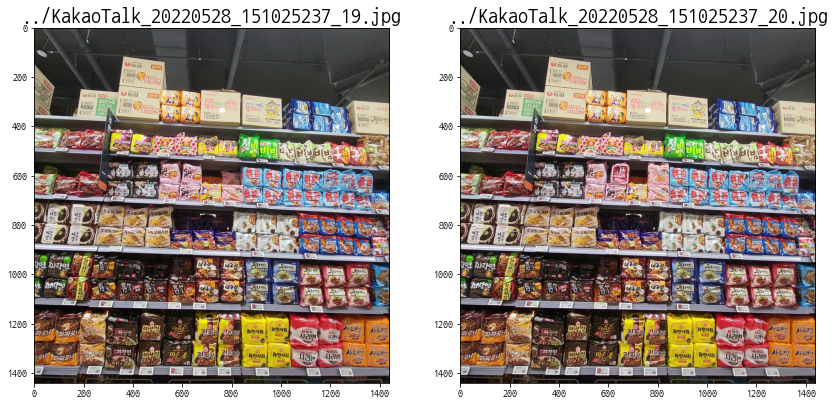

0.9318623221343397


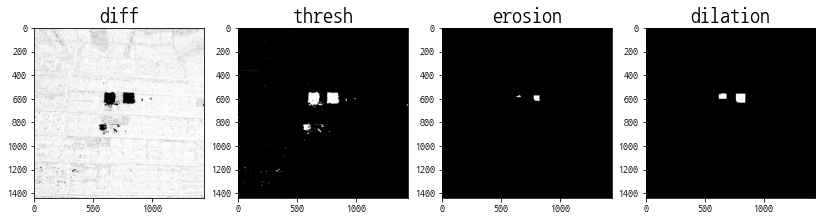

(762, 556, 80, 77): 0.225
(617, 554, 66, 46): 0.15316205533596838


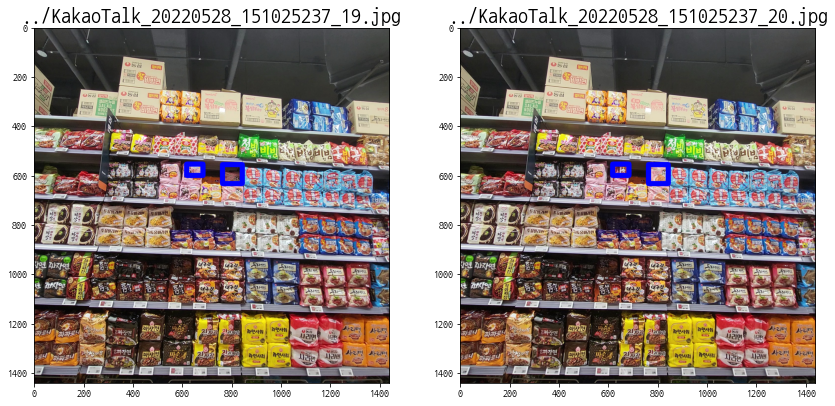

In [205]:
plot_all('../KakaoTalk_20220528_151025237_19.jpg', '../KakaoTalk_20220528_151025237_20.jpg')

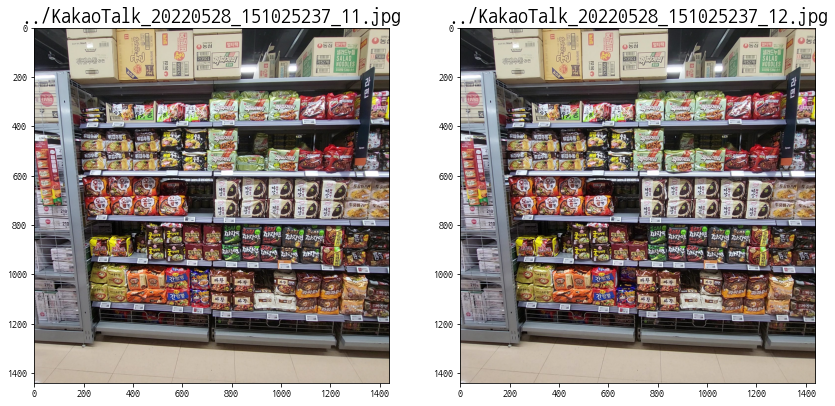

0.946384998855191


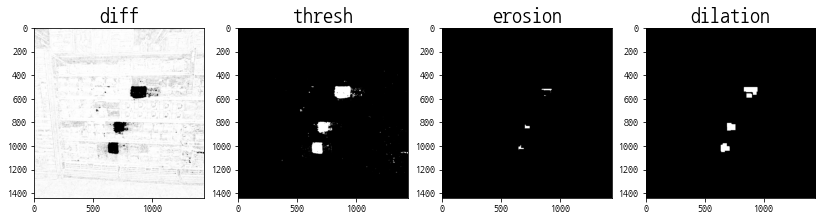

(633, 976, 76, 75): 0.5791228070175438
(686, 804, 72, 65): 0.33824786324786327
(851, 554, 47, 36): 0.0
(829, 500, 116, 66): 1.1210815047021943


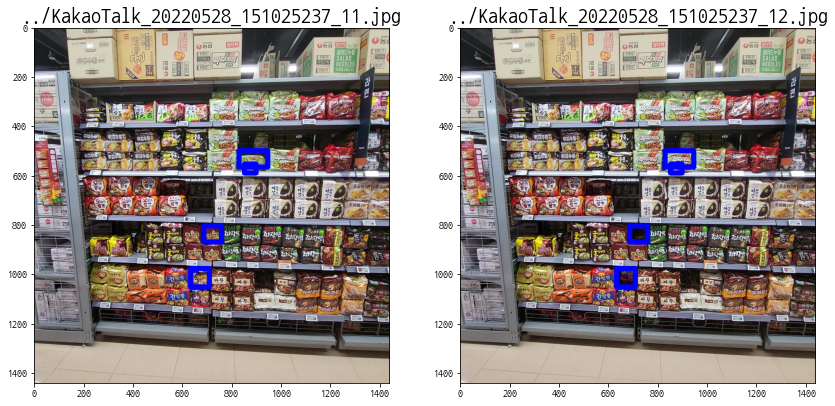

In [206]:
plot_all('../KakaoTalk_20220528_151025237_11.jpg', '../KakaoTalk_20220528_151025237_12.jpg')

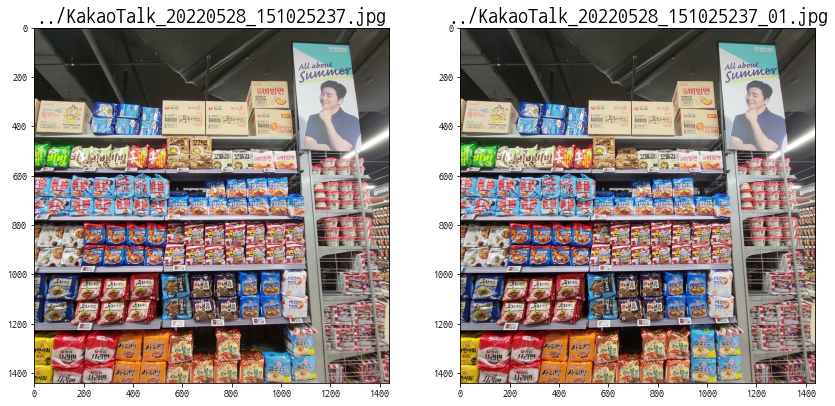

0.9120308028096672


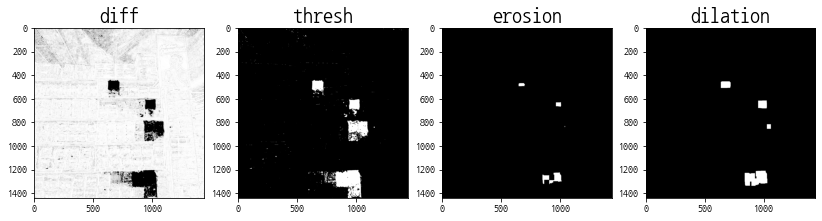

(836, 1209, 192, 128): 8.244344075520834
(1024, 815, 34, 39): 0.0
(950, 614, 74, 67): 0.0
(634, 452, 83, 56): 0.03937177280550774


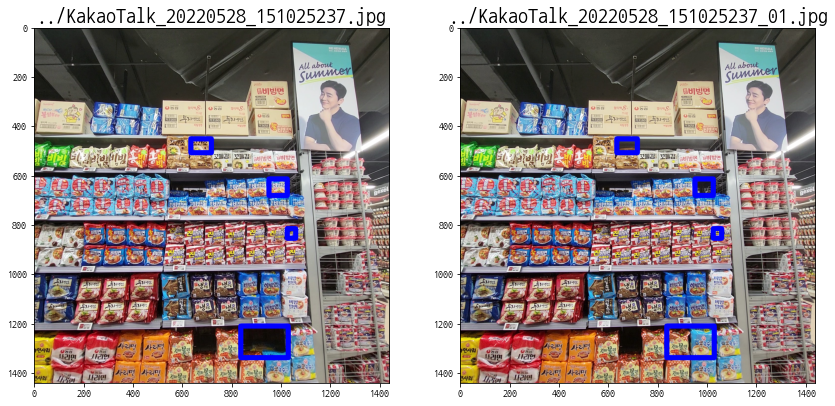

In [207]:
plot_all('../KakaoTalk_20220528_151025237.jpg', '../KakaoTalk_20220528_151025237_01.jpg')

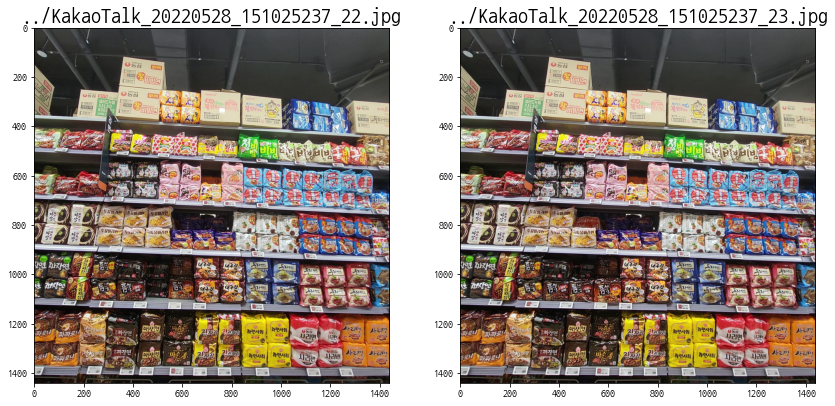

0.9205634327726364


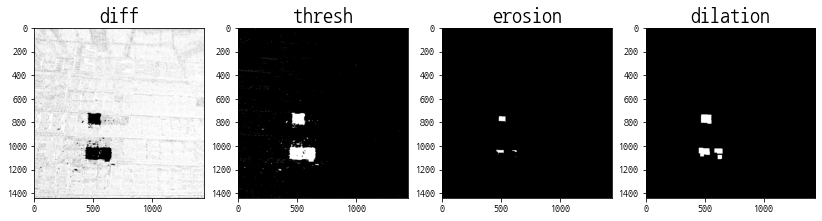

(607, 1075, 37, 36): 0.0
(579, 1020, 70, 44): 0.22207792207792207
(447, 1014, 94, 74): 0.8037665324899368
(466, 732, 89, 79): 1.7222301237377329


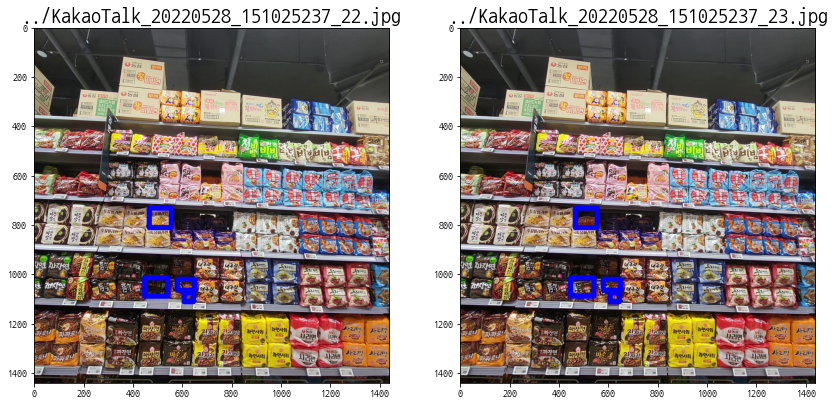

In [208]:
plot_all('../KakaoTalk_20220528_151025237_22.jpg', '../KakaoTalk_20220528_151025237_23.jpg')